<a href="https://colab.research.google.com/github/mille055/stanford_project/blob/dockerversion/app/notebooks/Stanford_CS231Ngamma2_display.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
COLAB_FLAG = True   # whether running on colab or locally on computer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
if COLAB_FLAG:
  %pip install pydicom==2.1.2
  %pip install monai seaborn sentence_transformers
  !git clone -b dockerversion 'https://github.com/mille055/stanford_project.git'
  

    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 117.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.9 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=09a3d8dcbf7654964425be493e233468f2dcfdf9b8adfb97ac864c1d3fa0cde8
  Stored in directory: 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import torchvision
import pydicom
import pickle
import glob
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

import seaborn as sns
from datetime import datetime

from sentence_transformers import SentenceTransformer

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import copy
from pprint import pprint
from fastai.basics import delegates
from fastcore.parallel import parallel
from fastcore.utils import gt
from fastcore.foundation import L

from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
import sys
import importlib
import warnings
from google.colab import drive
warnings.filterwarnings("ignore")

In [5]:
#local imports
if COLAB_FLAG:
    sys.path.append('/content/stanford_project/app/scripts/')
    train_datafile = '/content/stanford_project/app/data/trainfiles.csv'
    val_datafile = '/content/stanford_project/app/data/valfiles.csv'
    test_datafile = '/content/stanford_project/app/data/testfiles.csv'
    
    drive.mount('/content/gdrive')

else: # running locally
    sys.path.append('/Users/cmm/Documents/GitHub/new/stanford_project/app/scripts/')
    #sys.path.append('/workspaces/stanford_project/app/scripts/')
    train_datafile = '../data/trainfiles.csv'
    val_datafile = '../data/valfiles.csv'
    test_datafile = '../data/testfiles.csv'


### local imports ###
from config import file_dict, feats, feats_to_keep, column_lists, RF_parameters, classes, model_paths
from config import abd_label_dict, val_list, train_val_split_percent, random_seed, data_transforms
from config import sentence_encoder, series_description_column
from utils import *

from cnn.cnn_dataset import ImgDataset
from cnn.cnn_inference import image_to_tensor, pixel_inference, test_pix_model, load_pixel_model, visualize_results
from cnn.cnn_model import *
from cnn.cnn_training import *
from cnn.cnn_data_loaders import get_data_loaders, data_transforms, data_transforms2, data_transforms3

from model_container import ModelContainer



Mounted at /content/gdrive


In [6]:


train_df, val_df, test_df = create_datasets(train_datafile, val_datafile, test_datafile, '/volumes/cm7/Abdominal_MRI_dataset_split/', '/content/gdrive/MyDrive/WW_MRI_abd2/split/' )



In [7]:
# train_df = pd.read_pickle('/content/gdrive/MyDrive/train_df.pkl')
# val_df = pd.read_pickle('/content/gdrive/MyDrive/val_df.pkl')
# test_df = pd.read_pickle('/content/gdrive/MyDrive/test_df.pkl')

In [8]:
# Get the data loaders
batch_size = 16
train_loader, val_loader, test_loader, dataset_sizes = get_data_loaders(train_df, val_df, test_df, batch_size)
train_loader2, val_loader2, test_loader2, dataset_sizes2 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms2)
train_loader3, val_loader3, test_loader3, dataset_sizes3 = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=data_transforms3)
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataloaders2 = {'train': train_loader2, 'val': val_loader2, 'test': test_loader2}
dataloaders3 = {'train': train_loader3, 'val': val_loader3, 'test': test_loader3}


In [11]:
# Different combinations to evaluate
models = [CustomDenseNet]
loss_funcs = [FocalLoss]
loaders = ['dataloaders', 'dataloaders3']
loaders_dict = {'dataloaders': dataloaders, 'dataloaders2': dataloaders2, 'dataloaders3': dataloaders3}
optimizers = ['SGD', 'Adam']
optim_dict = {
    'SGD': {
        'class': torch.optim.SGD,
        'params': {'lr': 0.001, 'momentum': 0.9}
    },
    'Adam': {
        'class': torch.optim.Adam,
        'params': {'lr': 0.001, 'betas': (0.9, 0.999)}
    }
}


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



Training with CustomDenseNet, dataloaders, SGD, FocalLoss


100%|██████████| 30.8M/30.8M [00:00<00:00, 89.8MB/s]


Epoch 0/14
----------
train Loss: 1.3540 Acc: 0.4799
val Loss: 0.7149 Acc: 0.6667

Epoch 1/14
----------
train Loss: 0.4661 Acc: 0.7882
val Loss: 0.5353 Acc: 0.7316

Epoch 2/14
----------
train Loss: 0.2463 Acc: 0.8780
val Loss: 0.4276 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.1519 Acc: 0.9218
val Loss: 0.4191 Acc: 0.7938

Epoch 4/14
----------
train Loss: 0.1013 Acc: 0.9489
val Loss: 0.3718 Acc: 0.8192

Epoch 5/14
----------
train Loss: 0.0670 Acc: 0.9686
val Loss: 0.3629 Acc: 0.8220

Epoch 6/14
----------
train Loss: 0.0429 Acc: 0.9876
val Loss: 0.3496 Acc: 0.8164

Epoch 7/14
----------
train Loss: 0.0377 Acc: 0.9920
val Loss: 0.3524 Acc: 0.8164

Epoch 8/14
----------
train Loss: 0.0321 Acc: 0.9934
val Loss: 0.3459 Acc: 0.8249

Epoch 9/14
----------
train Loss: 0.0310 Acc: 0.9942
val Loss: 0.3526 Acc: 0.8220

Epoch 10/14
----------
train Loss: 0.0333 Acc: 0.9927
val Loss: 0.3508 Acc: 0.8305

Epoch 11/14
----------
train Loss: 0.0278 Acc: 0.9927
val Loss: 0.3412 Acc: 0.8249

Ep

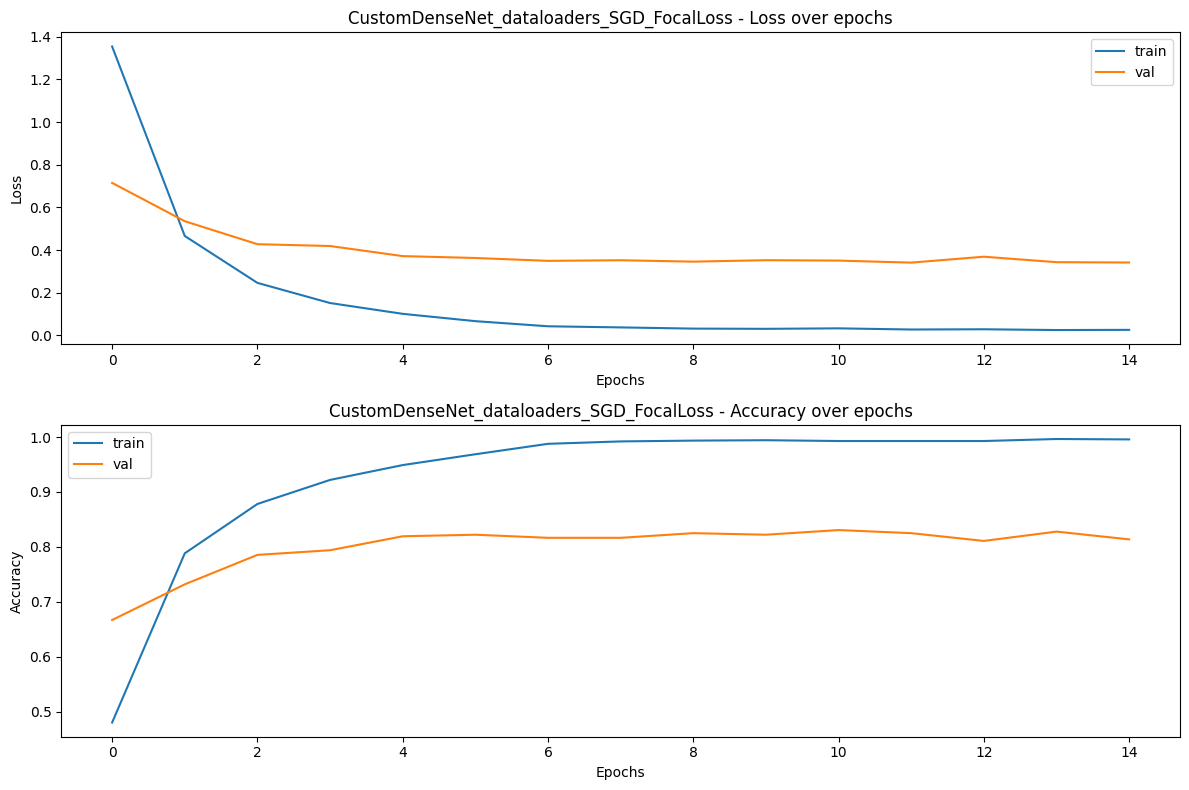


Training with CustomDenseNet, dataloaders, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 0.9961 Acc: 0.5676
val Loss: 1.0357 Acc: 0.6356

Epoch 1/14
----------
train Loss: 0.4999 Acc: 0.7363
val Loss: 0.5792 Acc: 0.7147

Epoch 2/14
----------
train Loss: 0.3471 Acc: 0.8006
val Loss: 0.6058 Acc: 0.7373

Epoch 3/14
----------
train Loss: 0.2820 Acc: 0.8349
val Loss: 0.7986 Acc: 0.6271

Epoch 4/14
----------
train Loss: 0.3094 Acc: 0.8167
val Loss: 0.6993 Acc: 0.6949

Epoch 5/14
----------
train Loss: 0.2091 Acc: 0.8641
val Loss: 0.4116 Acc: 0.8079

Epoch 6/14
----------
train Loss: 0.1533 Acc: 0.8897
val Loss: 0.4528 Acc: 0.7627

Epoch 7/14
----------
train Loss: 0.0838 Acc: 0.9364
val Loss: 0.2426 Acc: 0.8531

Epoch 8/14
----------
train Loss: 0.0412 Acc: 0.9722
val Loss: 0.2379 Acc: 0.8616

Epoch 9/14
----------
train Loss: 0.0300 Acc: 0.9788
val Loss: 0.2409 Acc: 0.8503

Epoch 10/14
----------
train Loss: 0.0228 Acc: 0.9832
val Loss: 0.2225 Acc: 0.8785

Epoch 11/14
----------
tra

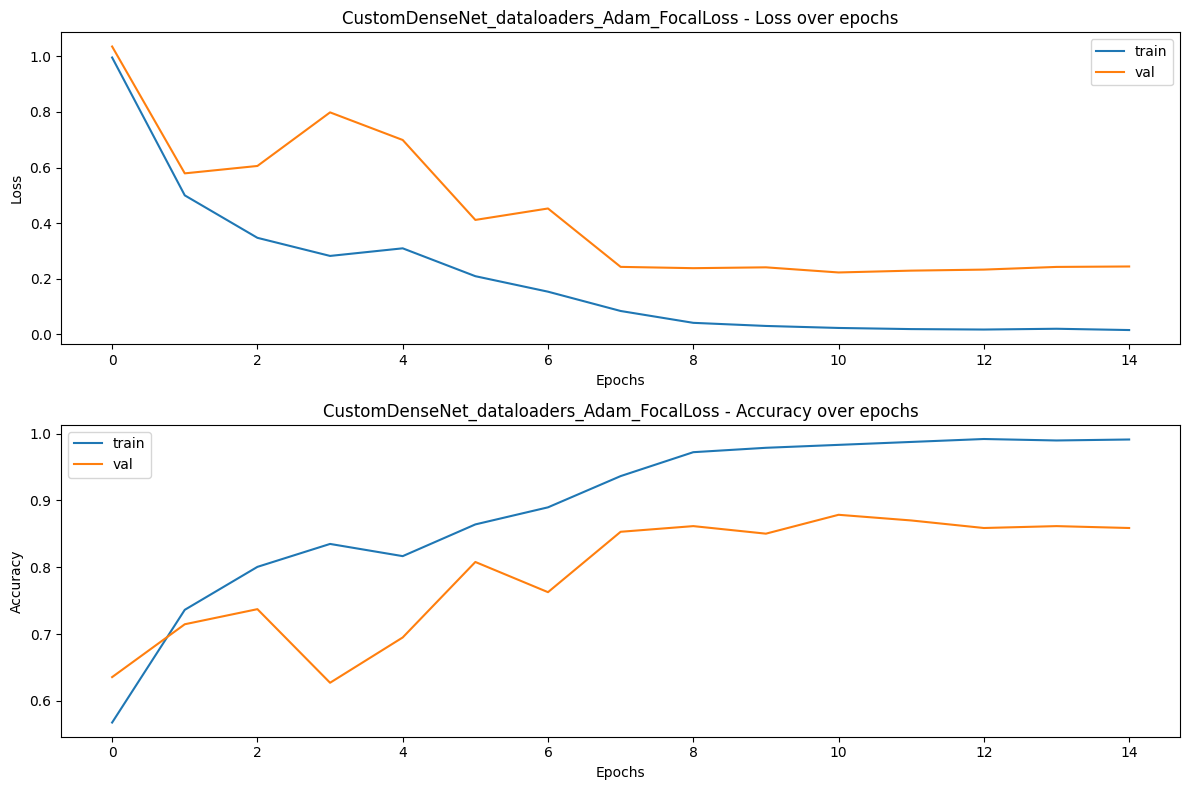


Training with CustomDenseNet, dataloaders3, SGD, FocalLoss
Epoch 0/14
----------
train Loss: 1.4722 Acc: 0.4390
val Loss: 0.7384 Acc: 0.6921

Epoch 1/14
----------
train Loss: 0.5562 Acc: 0.7509
val Loss: 0.5264 Acc: 0.7429

Epoch 2/14
----------
train Loss: 0.3394 Acc: 0.8276
val Loss: 0.4247 Acc: 0.7853

Epoch 3/14
----------
train Loss: 0.2395 Acc: 0.8692
val Loss: 0.3655 Acc: 0.8079

Epoch 4/14
----------
train Loss: 0.1583 Acc: 0.9189
val Loss: 0.3347 Acc: 0.8107

Epoch 5/14
----------
train Loss: 0.1286 Acc: 0.9262
val Loss: 0.3511 Acc: 0.8277

Epoch 6/14
----------
train Loss: 0.1020 Acc: 0.9408
val Loss: 0.3356 Acc: 0.8192

Epoch 7/14
----------
train Loss: 0.0639 Acc: 0.9671
val Loss: 0.3289 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0508 Acc: 0.9752
val Loss: 0.3184 Acc: 0.8305

Epoch 9/14
----------
train Loss: 0.0566 Acc: 0.9788
val Loss: 0.3205 Acc: 0.8192

Epoch 10/14
----------
train Loss: 0.0465 Acc: 0.9788
val Loss: 0.3183 Acc: 0.8164

Epoch 11/14
----------
tra

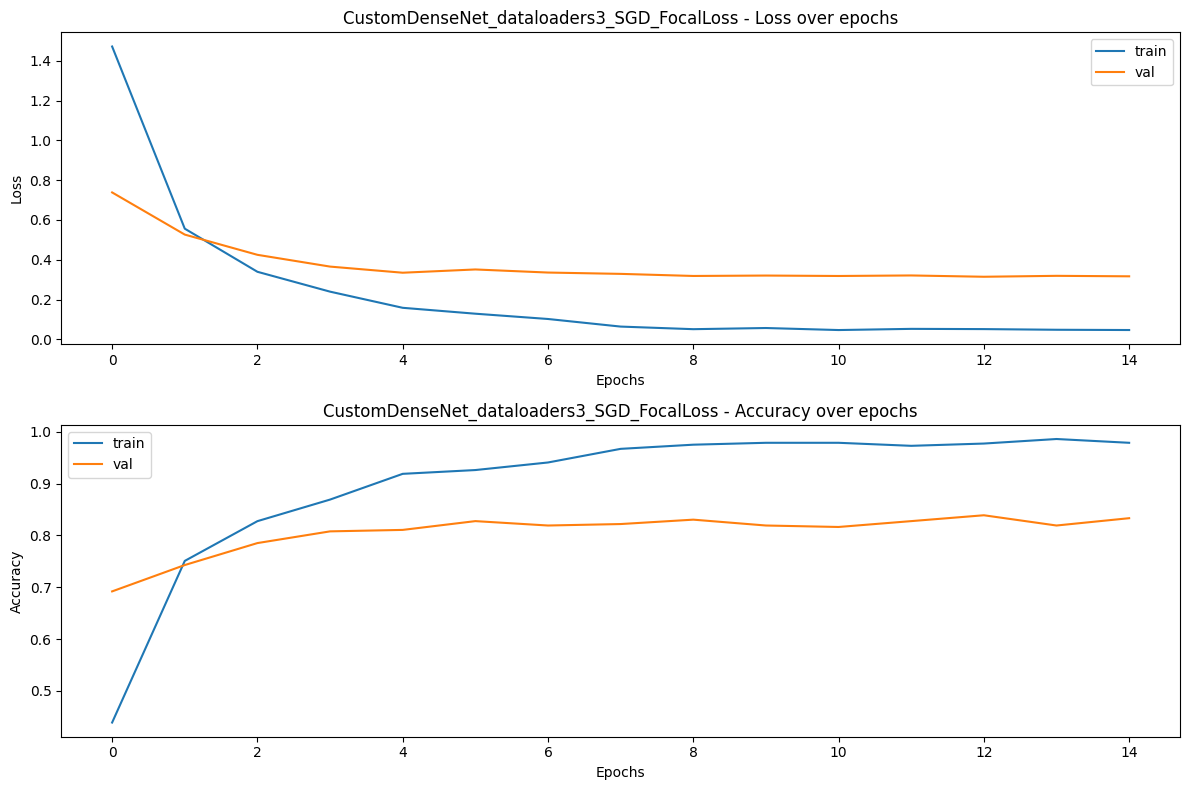


Training with CustomDenseNet, dataloaders3, Adam, FocalLoss
Epoch 0/14
----------
train Loss: 1.0360 Acc: 0.5537
val Loss: 0.8987 Acc: 0.5650

Epoch 1/14
----------
train Loss: 0.6056 Acc: 0.6983
val Loss: 0.7715 Acc: 0.6384

Epoch 2/14
----------
train Loss: 0.4879 Acc: 0.7429
val Loss: 0.5459 Acc: 0.7542

Epoch 3/14
----------
train Loss: 0.3331 Acc: 0.8050
val Loss: 0.7927 Acc: 0.6610

Epoch 4/14
----------
train Loss: 0.3429 Acc: 0.7860
val Loss: 0.9449 Acc: 0.6695

Epoch 5/14
----------
train Loss: 0.3087 Acc: 0.8123
val Loss: 0.4873 Acc: 0.7825

Epoch 6/14
----------
train Loss: 0.2494 Acc: 0.8291
val Loss: 0.5458 Acc: 0.7712

Epoch 7/14
----------
train Loss: 0.1397 Acc: 0.8934
val Loss: 0.3187 Acc: 0.8220

Epoch 8/14
----------
train Loss: 0.0748 Acc: 0.9459
val Loss: 0.3038 Acc: 0.8475

Epoch 9/14
----------
train Loss: 0.0619 Acc: 0.9489
val Loss: 0.3001 Acc: 0.8418

Epoch 10/14
----------
train Loss: 0.0526 Acc: 0.9569
val Loss: 0.2646 Acc: 0.8616

Epoch 11/14
----------
tr

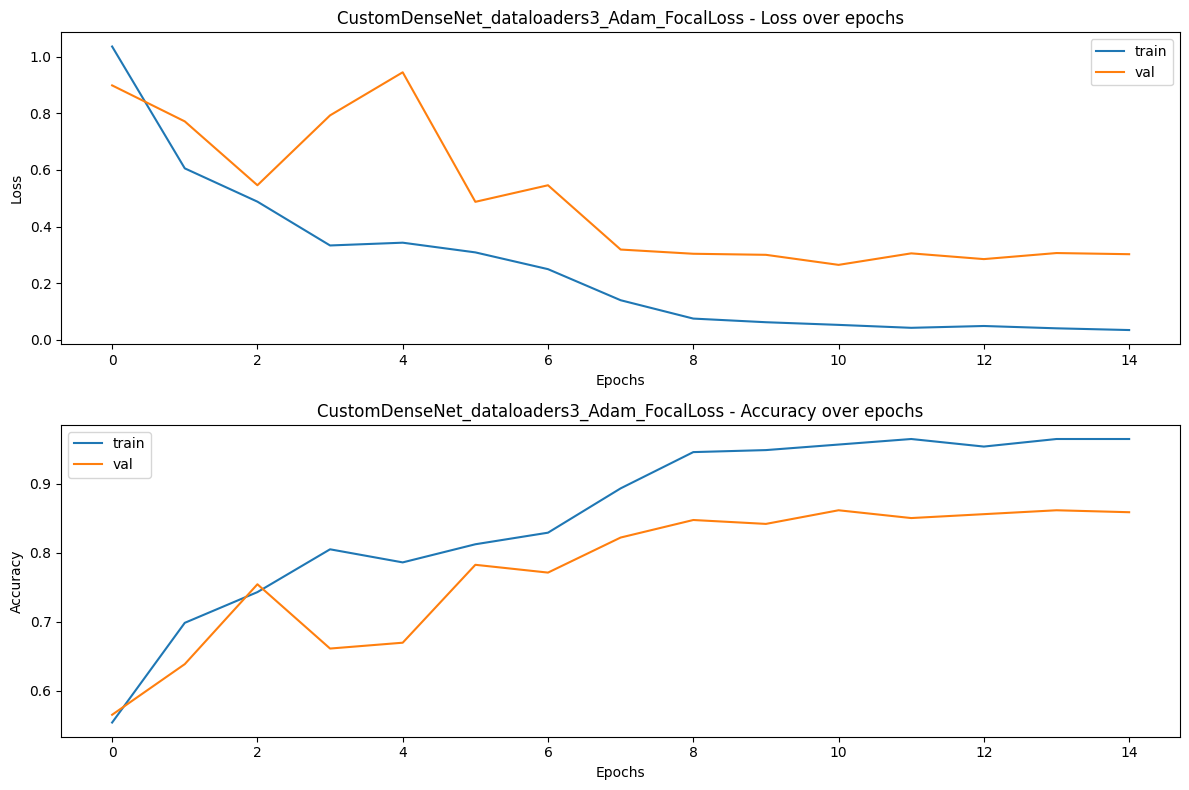

In [12]:
# perform several training runs to compare accuracy on the validation dataset
best_model = None
best_accuracy = -1

for model_class in models:
  for loader in loaders:
        for opt in optimizers:
            for loss_func_class in loss_funcs:
                print(f"\nTraining with {model_class.__name__}, {loader}, {opt}, {loss_func_class.__name__}")

                # Instantiate the custom model
                num_classes = len(classes)
                model = model_class(num_classes)
                model = model.to(device)  # Move the model to the appropriate device

                # Define loss function 
                criterion = loss_func_class()
               
                # Instantiate the selected optimizer with its parameters
                opt_class = optim_dict[opt]['class']
                opt_params = optim_dict[opt]['params']
                optimizer = opt_class(model.parameters(), **opt_params)
               
                #optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)

                # Decay LR by a factor of 0.1 every 7 epochs
                exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

                # Select the dataloader
                dataloaders = loaders_dict[loader]

                # Train the model
                trained_model, best_val_accuracy, history = train_cnn_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

                # Print the history data
                print("Training loss history:", history['train_loss'])
                print("Validation loss history:", history['val_loss'])
                print("Training accuracy history:", history['train_acc'])
                print("Validation accuracy history:", history['val_acc'])


                # Plot training curves
                combination_name = f"{model_class.__name__}_{loader}_{opt}_{loss_func_class.__name__}"
                plot_training_curves(history, combination_name)

                if best_val_accuracy > best_accuracy:
                  best_model = trained_model
                  best_accuracy = best_val_accuracy
               

In [13]:
def display_and_save_results2(y_pred, y_true, classes=classes, fn='', saveflag = True):
   

    classes_raw_list = np.unique(np.concatenate((y_true, y_pred)))
    print(classes_raw_list)
    classes_list = [classes[x] for x in classes_raw_list]
    print(classes_list)
    y_true = [classes[x] for x in y_true]
    y_pred = [classes[x] for x in y_pred]
    # Generate a confusion matrix based on the true labels and predicted labels
    cm = confusion_matrix(y_true = y_true, y_pred = y_pred, labels=classes_list)
  
    #mask = np.all(cm == 0, axis=1)

    class_text_labels = np.array([abd_label_dict[str(x)]['short'] for x in classes_list])
    #class_text_labels = class_text_labels[~mask]

     # Generate a classification report based on the true labels and predicted labels
    print(classification_report(y_true, y_pred))

    
    #cm = cm[~mask]
    # Create a ConfusionMatrixDisplay object with the correct labels
    cm_display = ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    plt.figure(figsize=(25, 25))
    plt.tight_layout()
    #ConfusionMatrixDisplay(cm, display_labels=class_text_labels).plot(xticks_rotation = 'vertical', cmap='Blues')
    if saveflag:
        plt.savefig("/content/FigCM_"+fn+datetime.today().strftime('%Y%m%d')+".tif",dpi=300, bbox_inches = 'tight')     

    return cm      



[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           2       0.91      0.86      0.88        49
           6       0.82      1.00      0.90        14
           7       0.94      0.94      0.94        18
           8       0.97      1.00      0.99        35
           9       1.00      0.94      0.97        34
          11       1.00      0.95      0.97        20
          12       0.80      0.33      0.47        12
          13       0.00      0.00      0.00         3
          14       0.95      1.00      0.97        19
          16       0.58      0.70      0.64        20
          17       1.00      0.94      0.97        17
          18       0.91      0.95      0.93        22
          19       0.90      0.95      0.92        19
          23       0.50      0.37      0.42        19
          25       0.77   

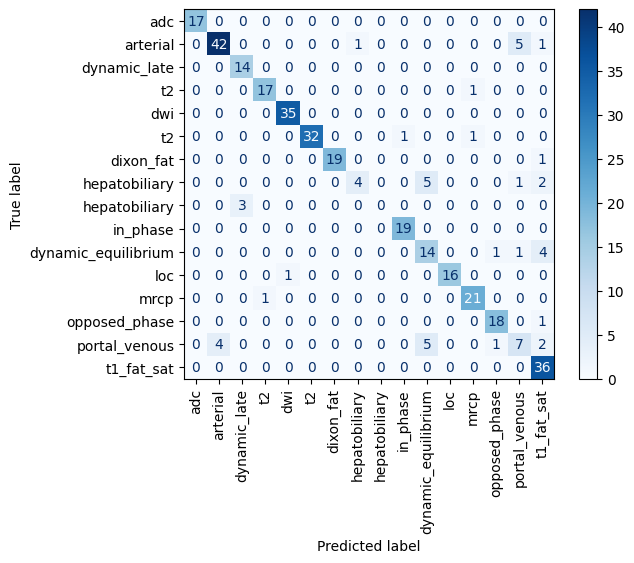

<Figure size 2500x2500 with 0 Axes>

In [14]:
# Evaluate the model on the val dataset
model = best_model

model.eval()
val_predictions = []
val_labels = []

for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        val_predictions.append(predicted.cpu().numpy())
        val_labels.append(labels.cpu().numpy())
val_predictions = np.concatenate(val_predictions, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(val_predictions, val_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


[ 0  1  2  3  4  5  7  8  9 10 12 13 14 15 17 18]
[0, 2, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 23, 25]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           2       0.93      0.85      0.89        61
           6       0.89      1.00      0.94        17
           7       1.00      1.00      1.00        22
           8       0.96      1.00      0.98        43
           9       1.00      0.95      0.98        42
          11       1.00      0.97      0.98        29
          12       0.80      0.40      0.53        10
          13       1.00      0.33      0.50         3
          14       0.95      0.83      0.88        23
          16       0.61      0.64      0.62        22
          17       1.00      0.95      0.98        21
          18       1.00      1.00      1.00        28
          19       0.82      1.00      0.90        23
          23       0.54      0.75      0.63        20
          25       0.94   

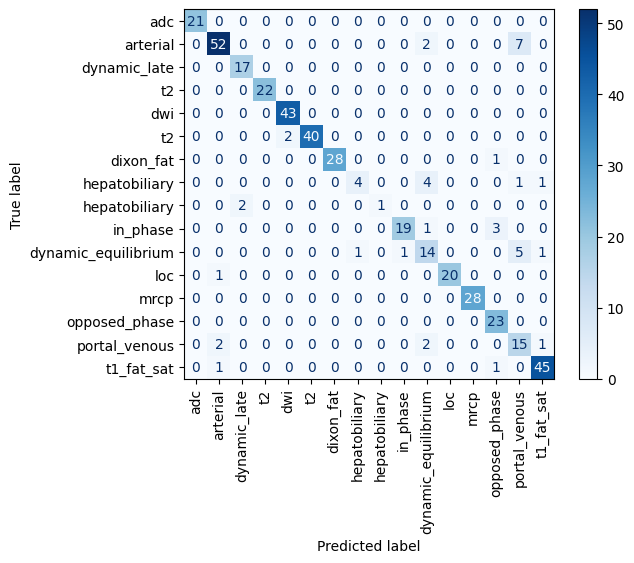

<Figure size 2500x2500 with 0 Axes>

In [15]:
# Evaluate the model on the test dataset
model = best_model

model.eval()
test_predictions = []
test_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad(): # No need to calculate gradients when doing inference
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1) # Get class from network's prediction
        test_predictions.append(predicted.cpu().numpy())
        test_labels.append(labels.cpu().numpy())
test_predictions = np.concatenate(test_predictions, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

#print(val_predictions)
#print(val_labels)
cm = display_and_save_results2(test_predictions, test_labels, classes, fn='DenseNetFL', saveflag=True)

# Save the trained model if needed
save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
torch.save(trained_model.state_dict(), '/content/gdrive/MyDrive/model0530b.pth')



# model.eval()
# val_predictions = []
# test_labels = []

# for inputs, labels in test_loader:
#     inputs = inputs.to(device)
#     labels = labels.to(device)
#     print(labels)
#     with torch.no_grad(): # No need to calculate gradients when doing inference
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1) # Get class from network's prediction
#         test_predictions.append(predicted.cpu().numpy())
#         test_labels.append(labels.cpu().numpy())

# print (test_predictions)
# print(test_labels)


# test_predictions = np.concatenate(test_predictions, axis=0)
# test_labels = np.concatenate(test_labels, axis=0)


# accuracy = np.sum(test_predictions==test_labels)/len(test_labels)
# print('Accuracy on the test dataset is ', np.round(accuracy, 3))
# #results = make_results_df(preds, true, test)

# # Save the trained model if needed
# save_filename = f"cnn_model_{combination_name}_{datetime.now().strftime('%Y%m%d')}.pth"
# torch.save(trained_model.state_dict(), save_filename)


In [ ]:
torch.save(trained_model.state_dict(), '/content/model0531a.pth')


In [16]:
!pip install transformers
from transformers import DeiTFeatureExtractor, DeiTForImageClassification



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
feature_extractor = DeiTFeatureExtractor.from_pretrained('facebook/deit-base-distilled-patch16-224')
batch_size = 16

optimizer = optim.Adam(deit_model.parameters(), lr=0.001, betas=(0.9,0.99))
criterion = FocalLoss()


def normalize_image(image):
    min_val = image.min()
    max_val = image.max()
    if min_val != max_val:
        image = (image - min_val) / (max_val - min_val)
    else:
        # Avoid zero division and return a zero image.
        image = torch.zeros_like(image)
    return image

class ImgDataset_deit(Dataset):
    def __init__(self, df, transform=None):
        self.data_df = df
        self.datafileslist = df.fname
        self.labels = df.label
        self.transform = transform
        
        
    def __len__(self):
        return self.data_df.shape[0]
    
    def __getitem__(self, idx):
      source = file_dict['img_data_dir_local']
      dest = file_dict['img_data_dir_colab']

      img_file = self.data_df.fname[idx]
      ds = pydicom.dcmread(img_file)
      img = ds.pixel_array.astype(np.float32)  # Convert to float
      img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize here
      print('img min:', np.min(img), 'img max:', np.max(img))
      img = torch.from_numpy(img)  # Convert to torch tensor
      img = img.repeat(3, 1, 1)  # Convert to 3-channel image

      if self.transform:
        img = self.transform(img)

      img = img[np.newaxis]
      # Apply feature extractor directly here
      img = feature_extractor(images=img, return_tensors="pt")["pixel_values"]
      print('now img min is ', np.min(img), 'img max is ', np.max(img))

      labl = self.data_df.label[idx]
      adjusted_label = classes.index(labl)
      y = torch.tensor(adjusted_label, dtype=torch.long) 

      return (img, y)



deit_transforms = {
    'train': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
]),
    'val': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ]),

    'test': transforms.Compose([
      transforms.ToPILImage(),
      transforms.Resize((224, 224)),
      transforms.Grayscale(num_output_channels=3),
      #transforms.Lambda(normalize_image),  # min-max normalization
      transforms.ToTensor()
    ])
}

def get_data_loaders_deit(train, val, test, batch_size, data_transforms = deit_transforms, shuffle=True, num_workers=0):
    # Create instances of your custom dataset
    train_imgdata = ImgDataset_deit(train, data_transforms['train'])
    val_imgdata = ImgDataset_deit(val, data_transforms['val'])
    test_imgdata = ImgDataset_deit(test, data_transforms['test'])

    # Create data loaders for the training, validation, and test datasets
    train_loader = DataLoader(train_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_imgdata, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    test_loader = DataLoader(test_imgdata, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    dataset_sizes = {'train': len(train_imgdata), 'val': len(val_imgdata)}

    return train_loader, val_loader, test_loader, dataset_sizes








train_loader_deit, val_loader_deit, test_loader_deit, dataset_sizes_deit = get_data_loaders(train_df, val_df, test_df, batch_size, data_transforms=deit_transforms)



Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTForImageClassification: ['cls_classifier.bias', 'distillation_classifier.weight', 'cls_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream t

In [18]:
def calc_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels.data)


In [19]:
def train_deit_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs.logits, labels)
                    _, preds = torch.max(outputs.logits, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [ ]:
deit_model = deit_model.to(device)
deit_model, train_acc, val_acc, train_loss, val_loss = train_deit_model(deit_model, {'train': train_loader_deit, 'val': val_loader_deit}, criterion, optimizer, num_epochs=25)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc.cpu(), label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.show()


Epoch 0/24
----------


In [ ]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Load pre-trained DeiT model and adjust the classifier for your number of classes
# deit_model = DeiTForImageClassification.from_pretrained('facebook/deit-base-distilled-patch16-224')
# num_classes = len(classes) # classes is your list of classes
# deit_model.classifier = torch.nn.Linear(in_features=model.classifier.in_features, out_features=num_classes)
# deit_model.to(device)

# # Define your loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(deit_model.parameters(), lr=0.001)

# num_epochs = 20

# # Start training
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(train_loader_deit, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = deit_model(inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#             running_loss = 0.0


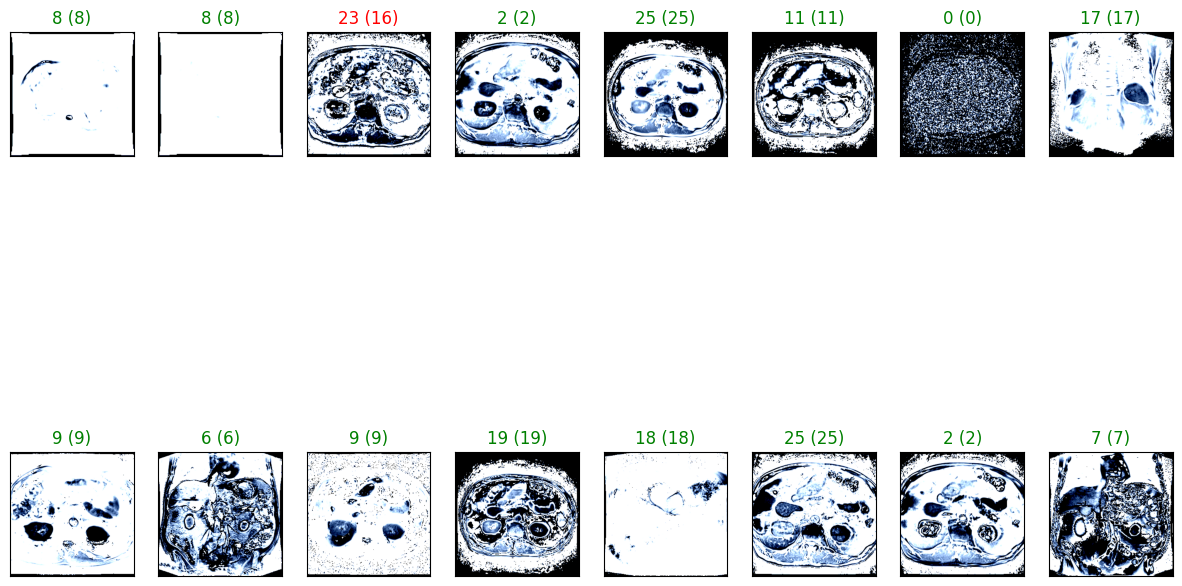

In [27]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(test_loader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels

        fig = plt.figure(figsize=(15, 10))
        for idx in np.arange(len(preds)):
          ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
          image = images[idx]
          image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
          image = np.clip(image, 0, 1)
          ax.imshow(image)
          ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
            color=("green" if preds[idx]==labels[idx] else "red"))

    return

visualize_results(best_model,test_loader,device)